<a href="https://colab.research.google.com/github/kolikaran1992/NLP/blob/master/Submission_%7C%7C_Karan_Singh_Koli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pandarallel

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# SETUP

In [61]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity


from gensim.models import Doc2Vec
from nltk.tokenize import word_tokenize

from pathlib import Path
import re
import typing
from collections import Counter
from tqdm import tqdm
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

seed = 42

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from pandarallel import pandarallel
import multiprocessing as mp

usable_cores = max(2, mp.cpu_count()-1)
pandarallel.initialize(progress_bar=True, nb_workers=usable_cores)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
ROOT_DIR = Path('/content/drive/MyDrive/Personal/Assignments/Hunch')

In [6]:
%time df = pd.read_csv(ROOT_DIR.joinpath('polls.csv'))

CPU times: user 98.9 ms, sys: 32.9 ms, total: 132 ms
Wall time: 161 ms


In [7]:
df.isna().sum()

question            0
categories          0
description     15812
PollOptions         0
all_comments     1417
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20345 entries, 0 to 20344
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   question      20345 non-null  object
 1   categories    20345 non-null  object
 2   description   4533 non-null   object
 3   PollOptions   20345 non-null  object
 4   all_comments  18928 non-null  object
dtypes: object(5)
memory usage: 794.9+ KB


# BASIC ANALYSIS


<Axes: >

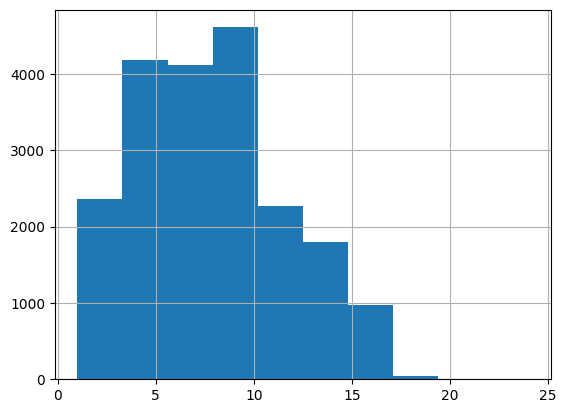

In [9]:
df['question_num_toks'] = df['question'].apply(lambda x: len(x.split()))
df['question_num_toks'].hist()

In [10]:
df['question_num_toks'].describe()

count    20345.000000
mean         7.795527
std          3.737302
min          1.000000
25%          5.000000
50%          7.000000
75%         10.000000
max         24.000000
Name: question_num_toks, dtype: float64

In [11]:
df['categories'].value_counts()

Dating and Relationships    7682
Friends and Family          1878
Language and Names          1600
Lifestyle                   1481
Philosophy and Religion      852
Technology and Internet      649
Food and Drinks              624
College Musings              623
Movies and TV                562
Music                        560
City Musings                 494
Would You Rather             456
Sports                       425
Health and Wellness          332
Anime                        322
Travel and Geography         298
Random                       199
Gaming                       197
Celebrities                  185
Finance                      163
Fashion and Makeup           158
Pets and Animals             138
Books and Comics             110
Bollywood                     98
Art Culture and History       69
Law and Order                 66
Nature                        49
Shopping                      38
Holidays                      26
Korean Movies and TV           8
Sneakers  

Although categories column isn't tested for accuracy it can still be used for finding out relevant patterns in the data by looking at texts in the same categories

1. Categroies can be thought of as a proxy for topics, since the texts in the data are short, therefore each text will almost always have only a single topic.
2. From the categories column it can be inferred that there should be around 31 topics in the data. But since the distribution of the categories is skewed (with minimum frequency 3), capturing all of these topics will be quite difficult.


In [12]:
df.query('categories == "Sneakers"')['question'].values.tolist()[:5]

['Any sneaker head? Which your favorite sneakers?',
 'Which Jordan retro should I buy ??',
 'Which jordan retro should i buy ?']

In [13]:
df.query('categories == "Shopping"')['question'].values.tolist()[:5]

['How often do girls do shopping',
 'Best c@r',
 'Have you ever stolen things from shop?',
 'If you had ₹6000, which one you will choose?',
 'https://nshkbyanushka.blinkstore.in/\nGuys check this store for']

In [14]:
df.query('categories == "Movies and TV"')['question'].values.tolist()[:5]

['Anyone watching HUSTLE3.0 ?? 🎤🔊',
 'Roadies is popular because of ---',
 'Which movie genre do you enjoy the most?',
 'WHICH OTT SUBSCRIPTION DO YOU HAVE ??',
 'What do you do for pastime when you have  some free  time']

In [15]:
df.query('categories == "Korean Movies and TV"')['question'].values.tolist()[:5]

['What did you mare prefer',
 'Delulu is the only solulu',
 'Best thriller k drama',
 'have you guys watched adult trainee?',
 'Which will be tough to fight in a Korean movie?']

From the above, it is evident that some lower frequency categories can be merged in higher frequency categories, for example, **Korean Movies and TV** can be merged in **Movies and TV** and **Sneakers** can be merged into **Shopping**.

This suggests that the actual number of topics that can be extracted while maintaining diversity among the topics should be lower than 31. But this depends on the tools that we have at our disposal, let's analyse the data further before concluding anything

Also, from the above it can be inferred that the question column only may not suffice to extract topics, some of the examples to support this hypothesis are

1. item number 15069 in the dataset has question column value = "What y'all prefer", it has been categorized in **Movies and TV**, which seems ambiguous given only the question column, but on observing the pollOptions and all_comments column values it seems reasonable
2. similar reasoning for item number 15042

# EMBEDDING GENERATOR

**Choosing Embedding Generator**

We can start with non semantic vectorizers (tfidf, bow etc) for vectorizing each row of the dataset, but it will only categorize texts in a single topic based on the tokens present in them. This type of vectorizer will fail for the cases where extra context might be required to understand the topic of the text, some examples to support this hypothesis are
1. item 20083 in the data talks about the character Chandler Bing's death from the TV series friends but this cannot be inferred from any of the columns
2. similar explanation for item 19387

Non semantic vectorizers might work well for categorizing rows which are in multiple languages in a single topic, this is due to the fact that most of the texts are in Hinglish and words that would tend the texts to fall in a particular topic would be same in either of the languages, some examples to support this hypothesis are

1. item 14904 talks about some of the Indian celebrities but the text is in Hinglish and item 2848 which is in english talks about same celebrity, therefore it will be difficult to cluster texts of these types under Movies and TV Series. But these can still be clustered together with texts which has the name Chandler in it
2. similar case for items 2292 and 2374


I did not choose to work with deep learning based embeddings since that would have been time consuming given the computational resources that I have

## TEXT PREPROCESSING

**Handling Emojis and Non Ascii Characters**

Emojis often are used to convey emotions in the textual information, they however do not change the actual content but only it's quality. I would want to keep them if I am aiming to create more diverse topics which might contain same content but are differed by the emotions the texts are trying to convey. A hypothetical example can be
1. "Rakhi Sawant is Cringe [smiley emoji]" and "Rakhi Sawant is Cringe [angry emoji]" both have the same context but the emotions being conveyed are totally different

Due to the above reasoning I am choosing to remove all non-ascii characters from the texts

Also a count based vectorizer won't benefit from non alphanumeric characters ([,./"' etc]), therefore I am choosing to ignore them

I am choosing to ignore the following from the texts
1. emojis: explained above
2. non alphanumeric characters: explained above
3. URLs: these wont add to the similarity of the texts even if I normalize them to a single token (example [URL] etc), there presence in the texts would only bring close the texts with similar number of URLs in them and might be considered as noise if the content in the texts is not similar

In [16]:
url_regex = r'https?:\S+|www\.\S+'
non_alphanumeric_regex = r'[^a-zA-Z0-9\s]'
def remove_urls(text: str) -> str:
    url_pattern = re.compile(url_regex)
    clean_text = url_pattern.sub('', text)
    return clean_text

def remove_hunchgif(text: str) -> str:
    # print(text)
    return text.lower().replace('(#hunch_gif)', '')

def remove_non_ascii(text):
    encoded_text = text.encode('ascii', 'ignore')
    cleaned_text = encoded_text.decode('ascii')
    return cleaned_text

def remove_non_alphanumeric(text: str) -> str:
    non_alphanumeric_pattern = re.compile(non_alphanumeric_regex)
    clean_text = non_alphanumeric_pattern.sub(' ', text)

    return clean_text

def pre_processing_pipeline(text: str) -> str:
    return remove_non_alphanumeric(remove_non_ascii(remove_hunchgif(remove_urls(text))))

In [17]:
_t = df[df['all_comments'].fillna('').apply(lambda x: bool(re.compile(url_regex).search(x)))]['all_comments'].iloc[3]
_t, pre_processing_pipeline(_t)

('https://media1.giphy.com/media/ypI2gLMW511fXr978a/giphy.gif?cid=479368cae37mohqllbgy0jwwz2gj8gx8f7bdwfgtj7v6s6w9&ep=v1_gifs_search&rid=giphy.gif&ct=g (#hunch_gif)  Aapko kaisa laga Nischay bhai ko hi karne do hum roohafza Maggi se khush hai🏴\u200d☠️ Icecream+chillie sauce ✅😌\nIcecream+brownie ❌👀',
 '   aapko kaisa laga nischay bhai ko hi karne do hum roohafza maggi se khush hai icecream chillie sauce \nicecream brownie ')

In [18]:
%%time
for col in ['question', 'PollOptions', 'all_comments', 'description']:
    df[f'{col}_processed'] = df[col].fillna('').parallel_apply(pre_processing_pipeline)

CPU times: user 343 ms, sys: 252 ms, total: 595 ms
Wall time: 1.52 s


## GENERATE TOKENIZER VOCAB

I will remove english stop words from the texts because they are easily accesible

In [63]:
stop_words = set(stopwords.words('english'))

In [64]:
def tokenize(text: str) -> typing.List[str]:
    return [tok for tok in text.split() if tok not in stop_words]

In [65]:
%time df['final_text'] = df.filter(regex='processed').apply(lambda x: ' '.join(x), axis=1)

CPU times: user 250 ms, sys: 2.6 ms, total: 253 ms
Wall time: 338 ms


In [66]:
def get_vocab_dict(all_texts: typing.List[str]) -> typing.Dict:
    vocab_dict = dict()
    for _text in tqdm(all_texts):
        for _tok in tokenize(_text):
            vocab_dict[_tok] = vocab_dict.get(_tok, 0) + 1

    return vocab_dict

In [22]:
%time vocab_dict = get_vocab_dict(df['final_text'].values.tolist())

100%|██████████| 20345/20345 [00:00<00:00, 67972.20it/s]

CPU times: user 290 ms, sys: 10.7 ms, total: 301 ms
Wall time: 310 ms


## TRAIN VECTORIZER

In [67]:
# min_df = 20 since I would want atleast 20 texts in a cluster
# removing such tokens otherwise they would constitute as noise
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, min_df=20)

In [68]:
%time tfidf_matrix = tfidf_vectorizer.fit_transform(df['final_text'].values.tolist())

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 564 ms, sys: 12.8 ms, total: 577 ms
Wall time: 576 ms


Setting min_df = 20 resulted in the following texts with vectors with all entries = 0, but there number isn't very high and upon a quick visual inspection it seems that we can ignore these since these are either in Hindi or have too few tokens to convey any meaning, in either case my choice of vectorizer will not capture any meaningful embeddings from these

In [69]:
df.loc[np.where(tfidf_matrix.sum(axis=1)==0)[0]]

,question,categories,description,PollOptions,all_comments,question_num_toks,question_processed,PollOptions_processed,all_comments_processed,description_processed,final_text
1699,🥹👍🏻,Language and Names,NaN,😎|😭,NaN,1,,,,,
2145,Bhh,Language and Names,https://assets.hunch.in/polls/490fbca6-f33a-43...,Vv|Ggji,NaN,1,bhh,vv ggji,,,bhh vv ggji
2923,!!,Language and Names,!!,!!!|!!,@safffaaan https://media2.giphy.com/media/iyd...,1,,,safffaaan,,safffaaan
2963,???,Movies and TV,NaN,??|???,https://media4.giphy.com/media/nTfdeBvfgzV26zj...,1,,,,,...
3340,परिवार में सबसे नटखट कौन होता हैं 👨‍👩‍👧‍👦,Friends and Family,NaN,बड़ा भाई 👦|छोटा भाई👦|छोटी बहन👧|बड़ी बहन👧🧕,NaN,8,,,,,
3535,This or that?,Anime,NaN,Kaito kidd 🌾|Shinichi kudo 🍁|Hatori 😎,This,3,this or that,kaito kidd shinichi kudo hatori,this,,this or that kaito kidd shinichi kudo hator...
3975,बल्ब का आविष्कार किसने किया ?,Art Culture and History,NaN,थॉमस अल्वा एडिसन|एलेग्जेंडर ग्राहम बेल,NaN,6,,,,,
5519,Kannadadavru yaradru iddira,Language and Names,NaN,Lmnic|Not me|Me,NaN,3,kannadadavru yaradru iddira,lmnic not me me,,,kannadadavru yaradru iddira lmnic not me me
8265,Nishaant,Friends and Family,Durlabh Kashyap Gangster,|||,NaN,1,nishaant,,,durlabh kashyap gangster,nishaant durlabh kashyap gangster
8550,তুর বাঁড়া,Language and Names,NaN,পাগ্গলা চোদা|লেওড়া,Aayien? কোনো ভাই Vai khanki magi chudi kemon?,2,,,aayien vai khanki magi chudi kemon,,aayien vai khanki magi chudi kemon


# LDA

LDA is the standard method for extracting topics from count based vectorizers therefore it will be a good starting point

In [70]:
def get_lda_model(n_comp: int) -> LatentDirichletAllocation:
    lda_model = LatentDirichletAllocation(n_components=n_comp, random_state=seed)
    lda_model.fit(tfidf_matrix)
    return lda_model

In [71]:
%time word_distances = pairwise_distances(tfidf_matrix, metric='euclidean')

CPU times: user 9.65 s, sys: 8.65 s, total: 18.3 s
Wall time: 18.9 s


In [113]:
%time lda_model = get_lda_model(15)

CPU times: user 45 s, sys: 176 ms, total: 45.2 s
Wall time: 45.7 s


To way to judge the topics quantitively is to see the perplexity as we change the number of topics

In [130]:
def get_score(lda_model):
    return lda_model.perplexity(tfidf_matrix)
    doc_topic_matrix = lda_model.transform(tfidf_matrix)
    max_values = doc_topic_matrix.max(axis=1)
    return {'mean': np.mean(max_values), 'std': np.std(max_values)}

In [177]:
num_topics = range(10, 45, 5)
all_scores = []
for n in tqdm(num_topics):
    lda_model = get_lda_model(n)
    all_scores.append(get_score(lda_model))

100%|██████████| 7/7 [06:34<00:00, 56.37s/it]


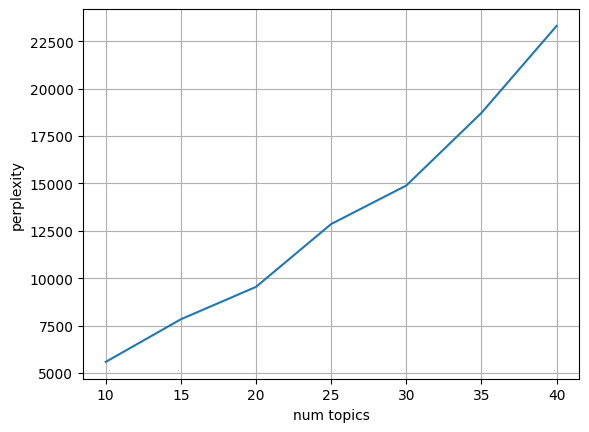

In [136]:
plt.plot(num_topics, [item for item in all_scores])
plt.xlabel('num topics')
plt.ylabel('perplexity')
plt.grid()
plt.show()

It seems that num_topics = 10 yields the best topic models

In [178]:
lda_model = get_lda_model(10)

In [179]:
doc_topic_matrix = lda_model.transform(tfidf_matrix)

In [180]:
doc_topic_matrix[3]

array([0.02659332, 0.02658849, 0.02658655, 0.02658746, 0.02659572,
       0.02658637, 0.02658648, 0.02659212, 0.76069495, 0.02658854])

# QUALITATIVE ASSESEMENT

In [140]:
from wordcloud import WordCloud

In [141]:
def generate_wordclouds(lda_model, vectorizer, num_words=10):
    """
    Generate word clouds for topics in an LDA model.

    Parameters:
    - lda_model: Trained LDA model
    - vectorizer: Text vectorizer (e.g., CountVectorizer or TfidfVectorizer)
    - num_words: Number of words to include in each word cloud

    Returns:
    - None (displays word clouds using matplotlib)
    """
    num_topics = lda_model.n_components
    feature_names = vectorizer.get_feature_names_out().tolist()

    for topic_idx, topic in enumerate(lda_model.components_):
        wordcloud_data = dict(zip(feature_names, topic))
        top_words_idx = topic.argsort()[:-num_words-1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(wordcloud_data)
        print(top_words)
        # Plot word cloud
        plt.figure(figsize=(5, 3))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {topic_idx + 1} Word Cloud')
        plt.axis('off')
        plt.show()


['yes', 'comment', 'like', 'money', 'lmkic', 'u', 'one', 'car', 'let', 'music']


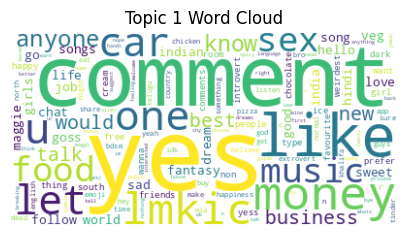

['delhi', 'truth', 'yes', 'mumbai', 'dare', 'anyone', 'city', 'male', 'cricket', 'india']


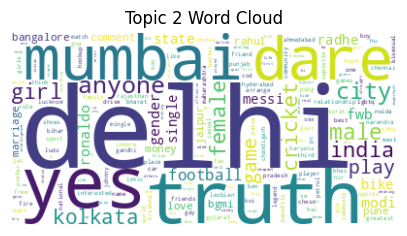

['girls', 'black', 'boobs', 'like', 'girl', 'yes', 'ass', 'hair', 'insta', 'boys']


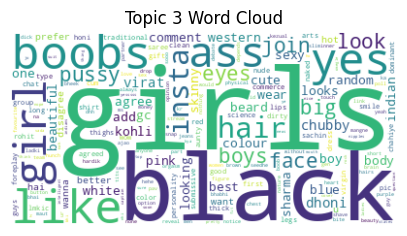

['anime', 'one', 'favourite', 'best', 'movie', 'choose', 'naruto', 'piece', 'fav', 'name']


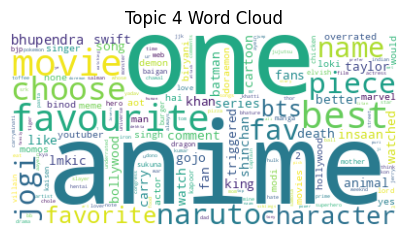

['hai', 'h', 'ho', 'nhi', 'kya', 'yes', 'bhai', 'bhi', 'girls', 'hi']


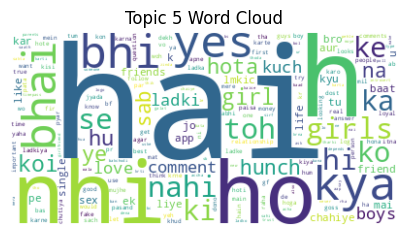

['hai', 'kya', 'nhi', 'h', 'nahi', 'se', 'ke', 'ho', 'bhai', 'bhi']


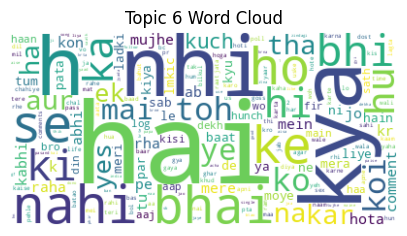

['1', '2', '5', '10', 'age', '3', '4', '18', '6', '20']


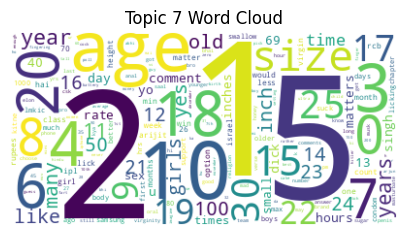

['moye', 'hai', 'hunch', 'kya', 'yes', 'position', 'doggy', 'instagram', 'birthday', 'ke']


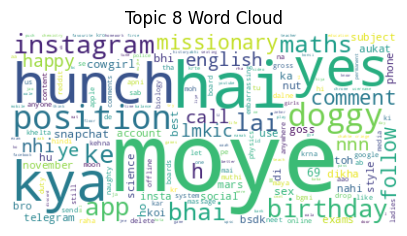

['yes', 'u', 'like', 'love', 'would', 'girl', 'one', 'girls', 'good', 'know']


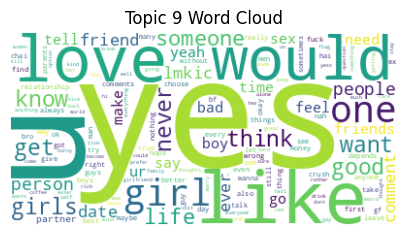

['night', 'morning', 'good', 'sleep', 'yes', 'watch', 'sorry', 'plz', 'kirti', 'unblock']


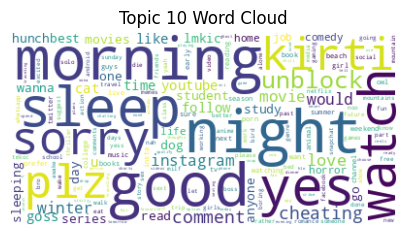

In [181]:
generate_wordclouds(lda_model, tfidf_vectorizer, num_words=10)

from the above word clouds it can be inferred that the people are talking about the following

topic 1: Music production and Distribution || since the prominent words contain
 comment, money, music, business, cars

topic 2: City and Games || since this topic contains prominent cities and names of popular games

topic 3: Girl specific slang and Instagram

topic 4: Anime and Movies

topic 5: random

topic 6: random

topic 7: Age description

topic 8: social media, memes and slang

topic 9: Relationships

topic 10: Texting

In [189]:
topic_mapping = {1: 'Music production and Distribution', 2: 'City and Games', 3: 'Girl specific slang and Instagram', 4: 'Anime and Movies', 5: 'random1', 6: 'random2', 7: 'Age Description', 8: 'Social Media, Memes and slang', 9: 'Relationships', 10: 'Texting'}

In [190]:
df['learned_topic'] = [topic_mapping[i] for i in doc_topic_matrix.argmax(axis=1) + 1]

In [191]:
df['learned_topic'].value_counts().reset_index().sort_values(by=['index'])

,index,learned_topic
6,Age Description,829
5,Anime and Movies,857
8,City and Games,720
7,Girl specific slang and Instagram,757
3,Music production and Distribution,1532
1,Relationships,4302
9,"Social Media, Memes and slang",665
4,Texting,1183
2,random1,2674
0,random2,6826


In [198]:
_t = df[['categories', 'learned_topic']].value_counts().reset_index().rename(columns={0: 'count'}).pivot(
    index='categories', columns=['learned_topic'], values=['count']
).T
(_t.div(_t.sum(axis=1), axis=0)*100).T

count                                  \
learned_topic            Age Description Anime and Movies City and Games   
categories                                                                 
Anime                           0.844391        19.603267       0.416667   
Art Culture and History         0.361882         0.350058       0.277778   
Bollywood                       0.120627         2.683781            NaN   
Books and Comics                     NaN         3.383897       0.138889   
Celebrities                     0.241255         8.401400       1.250000   
City Musings                    0.723764         0.350058      19.027778   
College Musings                 3.015682         0.350058       0.416667   
Dating and Relationships       41.737033         3.733956      28.611111   
Fashion and Makeup              0.844391         0.233372       0.277778   
Finance                         1.809409         0.116686            NaN   
Food and Drinks                 1.206273         8.401400       0.833333   
Friends and Family              5.548854         5.017503       6.527778   
Gaming                          0.120627         0.700117       8.333333   
Health and Wellness             1.930036              NaN       0.694444   
Holidays                        0.120627         0.233372            NaN   
Korean Movies and TV            0.120627         0.116686            NaN   
Language and Names              4.825090         3.500583       3.333333   
Law and Order                   0.241255         0.350058            NaN   
Lifestyle                       5.790109         0.350058       0.277778   
Movies and TV                   1.326900        18.669778       0.833333   
Music                           3.136309         9.334889       0.555556   
Nature                               NaN         0.350058       0.138889   
Pets and Animals                0.120627         1.400233            NaN   
Philosophy and Religion         5.307600         2.450408       2.916667   
Random                          1.568154         1.516919       1.805556   
Shopping                             NaN         0.116686       0.138889   
Sneakers                        0.120627              NaN       0.138889   
Sports                          4.342581         2.217036      13.888889   
Technology and Internet         7.237636         0.933489       0.833333   
Travel and Geography            1.326900         0.583431       5.555556   
Would You Rather                5.910736         4.550758       2.777778   

                                                            \
learned_topic            Girl specific slang and Instagram   
categories                                                   
Anime                                             0.792602   
Art Culture and History                           0.924703   
Bollywood                                         0.396301   
Books and Comics                                  0.264201   
Celebrities                                       0.528402   
City Musings                                      0.660502   
College Musings                                   1.321004   
Dating and Relationships                         45.706737   
Fashion and Makeup                                4.887715   
Finance                                           0.132100   
Food and Drinks                                   1.717305   
Friends and Family                                9.643329   
Gaming                                            0.396301   
Health and Wellness                               1.321004   
Holidays                                               NaN   
Korean Movies and TV                                   NaN   
Language and Names                                2.245707   
Law and Order                                          NaN   
Lifestyle                                         8.586526   
Movies and TV                                     0.792602   
Music                   

The column values sum to 1 and signify the percentage of the texts belonging to the topic which fall under category

In [200]:
ROOT_DIR.joinpath('Submission || Karan Singh Koli.ipynb').as_posix()

'/content/drive/MyDrive/Personal/Assignments/Hunch/Submission || Karan Singh Koli.ipynb'